# German_Traffic_Sign_Recognition
## About Dataset
### Context
The [German Traffic Sign Benchmark](https://www.kaggle.com/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign?datasetId=82373)
 is a multi-class, single-image classification challenge held at the International Joint Conference on Neural Networks (IJCNN) 2011. We cordially invite researchers from relevant fields to participate: The competition is designed to allow for participation without special domain knowledge. Our benchmark has the following properties:

* Single-image, multi-class classification problem
* More than 40 classes
* More than 50,000 images in total
* Large, lifelike database

**Acknowledgements** \
INI Benchmark Website


## Imports

In [1]:
import logging
import os

# ignore all the warning and debug information from tensorflow
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
logging.getLogger('tensorflow').setLevel(logging.ERROR)

from sklearn.metrics import classification_report
from libs.nn.conv.minivggnet import MiniVGGNet
import tensorflow as tf
from tensorflow import keras
from keras import layers
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as img
from pathlib import Path
import os

In [2]:

# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Prepare Dataset for training

In [3]:
# Look into the data directory
images_dir = './gtsrb-german-traffic-sign'

dataset_dir = f'{images_dir}/Train'

In [4]:
BATCH_SIZE = 32
IMG_WIDTH = IMG_HEIGHT = 32
RANDOM_STATE=123

In [5]:
classes = {0: 'Speed limit (20km/h)',
           1: 'Speed limit (30km/h)',
           2: 'Speed limit (50km/h)',
           3: 'Speed limit (60km/h)',
           4: 'Speed limit (70km/h)',
           5: 'Speed limit (80km/h)',
           6: 'End of speed limit (80km/h)',
           7: 'Speed limit (100km/h)',
           8: 'Speed limit (120km/h)',
           9: 'No passing',
           10: 'No passing veh over 3.5 tons',
           11: 'Right-of-way at intersection',
           12: 'Priority road',
           13: 'Yield',
           14: 'Stop',
           15: 'No vehicles',
           16: 'Veh > 3.5 tons prohibited',
           17: 'No entry',
           18: 'General caution',
           19: 'Dangerous curve left',
           20: 'Dangerous curve right',
           21: 'Double curve',
           22: 'Bumpy road',
           23: 'Slippery road',
           24: 'Road narrows on the right',
           25: 'Road work',
           26: 'Traffic signals',
           27: 'Pedestrians',
           28: 'Children crossing',
           29: 'Bicycles crossing',
           30: 'Beware of ice/snow',
           31: 'Wild animals crossing',
           32: 'End speed + passing limits',
           33: 'Turn right ahead',
           34: 'Turn left ahead',
           35: 'Ahead only',
           36: 'Go straight or right',
           37: 'Go straight or left',
           38: 'Keep right',
           39: 'Keep left',
           40: 'Roundabout mandatory',
           41: 'End of no passing',
           42: 'End no passing veh > 3.5 tons'}

In [6]:
len(classes.keys())

43

In [7]:
train_ds, val_ds = keras.utils.image_dataset_from_directory(
  dataset_dir,
  validation_split=0.2,
  subset="both",
  seed=RANDOM_STATE,
  shuffle=True,
  label_mode='categorical' ,
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  batch_size=BATCH_SIZE)

Found 39209 files belonging to 43 classes.
Using 31368 files for training.
Using 7841 files for validation.


In [8]:
classes  = train_ds.class_names
classes

['0',
 '1',
 '10',
 '11',
 '12',
 '13',
 '14',
 '15',
 '16',
 '17',
 '18',
 '19',
 '2',
 '20',
 '21',
 '22',
 '23',
 '24',
 '25',
 '26',
 '27',
 '28',
 '29',
 '3',
 '30',
 '31',
 '32',
 '33',
 '34',
 '35',
 '36',
 '37',
 '38',
 '39',
 '4',
 '40',
 '41',
 '42',
 '5',
 '6',
 '7',
 '8',
 '9']

In [9]:
for x, y in train_ds.take(1):
    print(x)
    print(y)
    break

tf.Tensor(
[[[[ 95.40918    96.18945    96.23633  ]
   [ 96.25928    93.7876     90.0874   ]
   [ 97.15723    93.31348    84.41748  ]
   ...
   [ 75.96875    79.30176    65.57764  ]
   [ 72.30908    76.35303    64.97803  ]
   [ 71.15723    75.0708     63.242676 ]]

  [[ 98.328125   99.55322   102.05957  ]
   [ 94.282715   94.67676    93.20459  ]
   [ 97.46777    98.3125     89.6875   ]
   ...
   [ 71.21875    76.17041    63.38965  ]
   [ 70.28662    75.16846    64.765625 ]
   [ 71.640625   74.481445   63.55957  ]]

  [[ 97.39697    99.86572   101.24072  ]
   [ 96.88916    99.24805    97.13867  ]
   [101.004395  104.38379    94.38818  ]
   ...
   [ 68.42432    74.975586   63.84619  ]
   [ 67.87598    74.28223    64.157715 ]
   [ 69.947754   72.65088    61.729004 ]]

  ...

  [[ 99.115234  106.54736    86.07861  ]
   [ 93.31494   100.32959    80.095215 ]
   [ 92.995605  100.265625   81.370605 ]
   ...
   [ 66.31006    67.35254    58.04004  ]
   [ 64.07617    64.186035   56.82715  ]
   [ 

Normalization

In [10]:
normalization_layer = keras.Sequential(
    [
        layers.Rescaling(1. / 255)
    ]
)

labels are already one-hot encoded, now we have to normalize the images, that will be done in side the model (1st Sequential layer)

Augmentation

In [11]:
data_augmentation = keras.Sequential(
    [
        layers.RandomRotation(0.3),
        layers.RandomZoom(0.2),
        layers.RandomFlip("horizontal_and_vertical"),
    ]
)

In [12]:
AUTOTUNE = tf.data.AUTOTUNE


def prepare(ds, shuffle=False, augment=False):
    # Resize and rescale all datasets.
    ds = ds.map(lambda x, y: (normalization_layer(x), y),
                num_parallel_calls=AUTOTUNE)

    if shuffle:
        ds = ds.shuffle(1000)

    # Use data augmentation only on the training set.
    if augment:
        ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y),
                    num_parallel_calls=AUTOTUNE)

    # Use buffered prefetching on all datasets.
    return ds.prefetch(buffer_size=AUTOTUNE)

In [13]:
train_aug_ds = prepare(train_ds, shuffle=True, augment=True)
val_ds = prepare(val_ds)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


## Prepare CNN Model

Setting up the callbacks

In [14]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=20,
                                                     restore_best_weights=True)
                                                     
SAVED_MODEL_PATH = 'model/ge_traffic_sign_recognition.h5'
model_checkpoint_cb = keras.callbacks.ModelCheckpoint(SAVED_MODEL_PATH, 
                                                      monitor="val_loss", 
                                                      mode="min",
                                                      save_best_only=True, 
                                                      verbose=1)


callbacks = [early_stopping_cb, model_checkpoint_cb]

In [15]:
model = MiniVGGNet.build(width=IMG_WIDTH, height=IMG_HEIGHT, depth= 3, classes=len(classes))

In [16]:
EPOCHS = 50
lr = 1e-2
# optimizer = tf.keras.optimizers.SGD(learning_rate=lr , weight_decay=lr /EPOCHS, momentum=0.9, nesterov=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr , weight_decay=lr /EPOCHS)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_1 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                      

Configure the dataset for performance

In [17]:
train_ds = train_aug_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Train the Model

In [18]:
# tf.keras.backend.clear_session()
tf.random.set_seed(RANDOM_STATE)

In [19]:
history = model.fit(train_ds,
                        validation_data=val_ds,
                        batch_size=BATCH_SIZE,
                        epochs=EPOCHS,
                        callbacks=callbacks)

Epoch 1/50


2023-02-19 10:30:46.400410: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_2/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


981/981 [==============================] - ETA: 0s - loss: 2.3680 - accuracy: 0.3502
Epoch 1: val_loss improved from inf to 1.69615, saving model to model/ge_traffic_sign_recognition.h5
981/981 [==============================] - 9s 6ms/step - loss: 2.3680 - accuracy: 0.3502 - val_loss: 1.6962 - val_accuracy: 0.4473
Epoch 2/50
973/981 [============================>.] - ETA: 0s - loss: 1.2211 - accuracy: 0.6060
Epoch 2: val_loss improved from 1.69615 to 0.60909, saving model to model/ge_traffic_sign_recognition.h5
981/981 [==============================] - 6s 6ms/step - loss: 1.2186 - accuracy: 0.6067 - val_loss: 0.6091 - val_accuracy: 0.7916
Epoch 3/50
976/981 [============================>.] - ETA: 0s - loss: 0.7817 - accuracy: 0.7463
Epoch 3: val_loss improved from 0.60909 to 0.33819, saving model to model/ge_traffic_sign_recognition.h5
981/981 [==============================] - 6s 6ms/step - loss: 0.7811 - accuracy: 0.7465 - val_loss: 0.3382 - val_accuracy: 0.8925
Epoch 4/50
981/981 

## Evaluate the Model

In [20]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

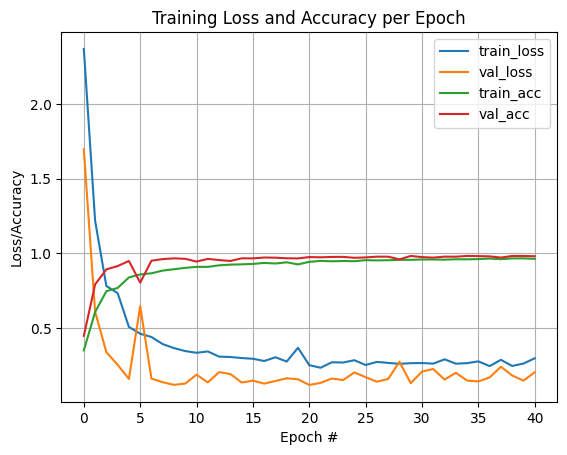

In [27]:
plt.figure()
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.plot(history.history["accuracy"], label="train_acc")
plt.plot(history.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy per Epoch")
plt.grid()
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()

In [22]:
loss, accuracy = model.evaluate(val_ds)
loss, accuracy

246/246 [==============================] - 0s 2ms/step - loss: 0.1191 - accuracy: 0.9749


(0.11913761496543884, 0.9748756289482117)

In [23]:
predicted = model.predict(val_ds)
for pred in predicted[:3]:
    print(np.argmax(pred, axis=-1))

246/246 [==============================] - 0s 1ms/step
12
10
25


In [24]:
def get_actual_predicted_labels(dataset): 
  """
    Create a list of actual ground truth values and the predictions from the model.

    Args:
      dataset: An iterable data structure, such as a TensorFlow Dataset, with features and labels.

    Return:
      Ground truth and predicted values for a particular dataset.
  """
  actual = [labels for _, labels in dataset.unbatch()]
  predicted = model.predict(dataset)

  actual = tf.stack(actual, axis=0)
  actual =np.argmax(actual, axis=1) # because one hot encoded 
  predicted = tf.concat(predicted, axis=0)
  predicted = tf.argmax(predicted, axis=1)

  return actual, predicted

In [25]:
actual, predicted = get_actual_predicted_labels(val_ds)
actual[:10], predicted[:10].numpy()

246/246 [==============================] - 0s 1ms/step


(array([12, 10, 25, 18,  4, 33, 14, 22, 35,  1]),
 array([12, 10, 25, 18,  4, 33, 14, 22, 35,  1]))

In [26]:
print(classification_report(actual, predicted,
                            target_names=classes))

              precision    recall  f1-score   support

           0       0.94      0.94      0.94        48
           1       0.98      0.96      0.97       468
          10       1.00      1.00      1.00       418
          11       0.96      0.99      0.97       275
          12       1.00      1.00      1.00       425
          13       1.00      0.99      0.99       449
          14       1.00      0.99      1.00       156
          15       0.98      0.98      0.98       127
          16       0.95      0.99      0.97        78
          17       1.00      1.00      1.00       225
          18       0.99      0.98      0.98       234
          19       1.00      0.91      0.95        54
           2       0.93      0.99      0.96       442
          20       0.94      1.00      0.97        84
          21       0.71      1.00      0.83        63
          22       1.00      1.00      1.00        90
          23       1.00      0.83      0.91       100
          24       0.90    